## Simple time integration - the Euler method

In this unit we begin with Newton's second law

$$F = ma$$

and apply it to the problem of a falling body,
$$F = -mg$$

where $m$ is the mass of the body and $g$ = 9.8 $\textrm{m/s}^2$. Assume the body falls along the y-axis, then from the definition of acceleration we know

$$\frac{d^2y}{dt^2} = -g$$

Pause to note that this is called a *second-order ordinary differential equation*. Second order because it is a second derivative, ordinary because the function $y$ is a function of one variable only, $t$ and differential because it relates rates of change through derivatives. This terminology will be important!

The analytic solution to this equation can be arrived at by integrating the equation twice, yielding
$$ \frac{dy}{dt} = v(t) = v(0) -gt$$
$$y(y) = -\frac{1}{2}gt^2 + v(0) t +y(0).$$

You no doubt explored various problems that can be solved with that pair of equations in previous physics classes. They work well. For the sake of this class, and a simple starting point, let us solve these equations *numerically*. The derivatives we are interested in are:

$$\frac{dy}{dt} = v$$ and,
$$\frac{dv}{dt} = -g$$

If we recall our calculus, the definition of a derivative is the following:

$$ \lim_{\Delta t \rightarrow 0} \frac{y(t+\Delta t) - y(t)}{\Delta t} = v(t)$$ and,
$$ \lim_{\Delta t \rightarrow 0} \frac{v(t+\Delta t) - v(t)}{\Delta t} = -g(t)$$

If we assume that we can use floating point arithmetic to get a $\Delta t$ sufficiently small, then we can begin treating $\Delta t$ as an algebraic quantity, allowing us to solve the equations for what will happen next, $t+\Delta t$ in terms of now, $t$

$$y(t+\Delta t) = y(t) + v(t) \Delta t$$
$$v(t+\Delta t) = v(t) - g(t) \Delta t$$

Note that we have effectively transformed a second order ordinary differential equation, $\frac{d^2y}{dt^2} = -g$ into a pair of first order differential equations. This method amounts to using information at the beginning of the time interval to assess slopes $v(t)$ and $g(t)$. It is called the *Euler Method* and is a good starting point for studying how ODEs are solved numerically.

### Numerical solution

Now, let us write a general interface to solving such equations. It was helpful to think of Newton's second law in the context of gravity to see the relation between forces and second order ordinary differential equations. However, as we begin to write software, we'd like something more general. In very general terms, we are trying to solve equations of the form

$$\frac{d \mathbf{y}}{dt} = f(y,t)$$

where $\mathbf{y}$ is a vector with multiple values, and $f(y,t)$ returns one value for each $\mathbf{y}$. Specifically, $f(y,t)$ is a function that accepts values of $\mathbf{y}$, and returns their derivatives! If those derivatives explicitly depend on $t$, then the system is said to be *non-autonomous*. For most of our examples, the systems will be *autonomous* or independent of explicit $t$ dependence.

We'd like to abstract that $f(y,t)$ and write a function to take the system from $t$ to $\Delta t$.

### Problem 1

Write a function, called `solve_ode` according to the signature below. While it's rare that I'm so specific about the required interface to your solutions, you will later learn that if you do it this way, moving to the pre-written ODE solvers will be much easier. The challenging portions are to proper use of function handles, including the function handle for the keyword `method` and the use of `*args` and `**options` (or, often `**kwargs`). Consult Python documentation if you are not familiar with these features of the language.

Finally observe that data will have to be managed internally, and that lists are well suited to the task. However, they will have to be converted to `numpy arrays` upon return from the function.

*in-class* - discuss the following solver with the people sitting near you and come up with implementation plans. Be especially conscience of the `*args`, `**options`, function handles, and modes of storing data within a central loop over time.

In [214]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [215]:
def Euler(y, dt, f, t, *args):
    """ Computes the change in state via the Euler algorithm """
    return f(t, y, *args) * dt + y


def EulerCromer(y, dt, f, t, *args):
    """ Computes the change in state via the Euler-Cromer method """
    y_end = Euler(y, dt, f, t, *args)
    return f(t + dt, y_end, *args) * dt + y


def EulerRichardson(y, dt, f, t, *args):
    """ Computes the change in state via the Euler-Richardson method """
    y_mid = Euler(y, dt/2, f, t, *args)
    return f(t + dt/2, y_mid, *args) * dt + y
    

def solve_ode(f, tspan, y0, method=Euler, *args, **options):
    """
    Given a function f that returns derivatives,
    dy / dt = f(t, y)
    and an inital state:
    y(tspan[0]) = y0

    This function will return the set of intermediate states of y
    from t0 (tspan[0]) to tf (tspan[1])



    The function is called as follows:

    INPUTS

    f - the function handle to the function that returns derivatives of the
        vector y at time t. The function can also accept parameters that are
        passed via *args, eg f(t,y,g) could accept the acceleration due to gravity.

    tspan - a indexed data type that has [t0 tf] as its two members.
            t0 is the initial time
            tf is the final time

    y0 - The initial state of the system, must be passed as a numpy array.

    method - The method of integrating the ODEs. This week will be one of Euler,
             Euler-Cromer, or Euler-Richardson

    *args - a tuple containing as many additional parameters as you would like for
            the function handle f.

    **options - a dictionary containing all the keywords that might be used to control
                function behavior. For now, there is only one:

                first_step - the initial time step for the simulation.


    OUTPUTS

    t,y

    The returned states will be in the form of a numpy array
    t containing the times the ODEs were solved at and an array
    y with shape tsteps,N_y where tsteps is the number of steps
    and N_y is the number of equations. Observe this makes plotting simple:

    plt.plot(t,y[:,0])

    would plot positions.

    """
    # Add some error handling
    # Pull dt out of options
    dt = options['first_step']
    t0 = tspan[0]
    tf = tspan[1]
    y = [y0]
    t = [t0]
    while t[-1] < tf:
        # Compute change in t and change in position y at each time step
        y.append(method(y[-1], dt, f, t[-1], *args))  
        t.append(t[-1] + dt)

    # Convert t, y to np arrays and return them
    return np.array(t), np.array(y)

### Problem 2

Now implement the ODEs at the beginning of this discussion,

$$\frac{dy}{dt} = v$$ and,
$$\frac{dv}{dt} = -g$$

where $g$ is 9.8 $\frac{m}{s^2}$. These physics should enter as a function called `falling_body(t,y,g)`. 

Integrate this function using the Euler method. Use $\mathbf{y}_0 = (y_0,v_0) = (3,0)$. Begin at $t_0$= 0, and end at time $t_f=\sqrt{\frac{6}{g}}$. Plot your results. Label the axes with titles and appropriate units.



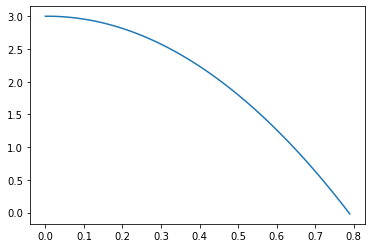

In [216]:
def simple_gravity(t, y, g):
    """
    This describes the ODEs for the kinematic equations:
    dy/dt =  v
    dv/dt = -g
    """
    result = y[1], -g
    return np.array(result)

g = 9.8
y_0 = np.array([3, 0])
delta_t = 0.01
time_interval = (0, np.sqrt(6/g))
t_e, y_e = solve_ode(simple_gravity, time_interval, y_0, Euler, g, first_step=delta_t)
plt.plot(t_e, y_e[:, 0])
plt.show()

### Problem 3

*In class* - think about and see if you can think of ways of improving upon the Euler method. Be sure to discuss the core function of what Euler is doing and where it is doing it.

Now add the Euler Cromer and Euler Richardson methods for integrating the ODEs. The methods are to evaluate slopes at the beginning of the time interval, Euler, evaluating the slopes at the end of the interval, Euler Cromer, and evaluating slopes at the middle of the interval, Euler Richardson.

#### Euler Method

Slopes at the beginning:

$$y(t+\Delta t) = y(t) + \frac{dy}{dt}(t,y)\Delta t$$

#### Euler Cromer Method

Slopes at the end:

$$y_{end} = y(t) + \frac{dy}{dt}(t,y) \Delta t$$
$$y(t+\Delta t) = y(t) + \frac{dy}{dt}(t+\Delta t,y_{end}) \Delta t$$


**Note -** *a small improvement for some systems can be achieved by first finding the new postion using an Euler step,starting at time $t$ and then using the result of this to find the update to the velocity, using position $y(t+\Delta t)$. This is probably the true intent of the algorithm, but that makes the algorithm too specialized, so we'll use the formula above.*

#### Euler Richardson Method
Slopes in the middle:

$$y_{mid} = y(t) + \frac{dy}{dt}(t,y) \frac{\Delta t}{2}$$
$$y(t+\Delta t) = y(t) +  \frac{dy}{dt}(t+\frac{\Delta t}{2},y_{mid}) \Delta t$$

### Problem 4

Use the newly implemented algorithms to redo the falling body simulation. Plot all three on the same axes and create a legend. Explore how differences in accuracy are seen as $\Delta t$ is varied. What $\Delta t$ is required for good results for each of the three algorithms? For comparison and calculation of error, use the analytic solution

$$y(t) = -\frac{1}{2}gt^2+v_0t+y_0.$$


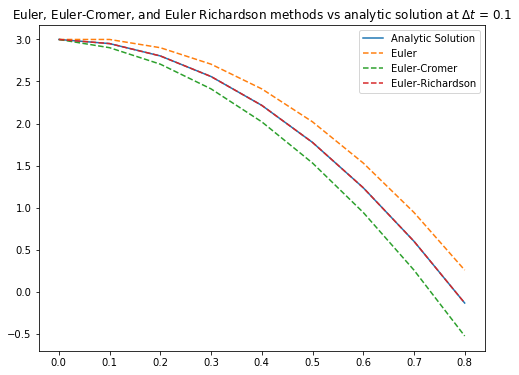

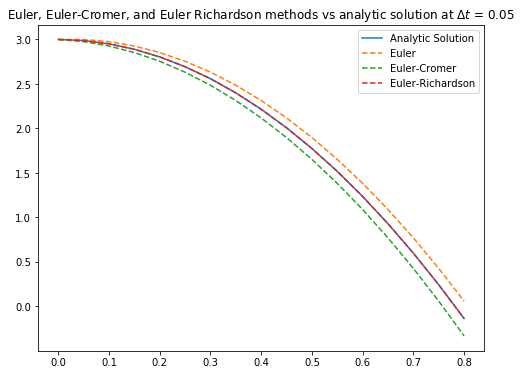

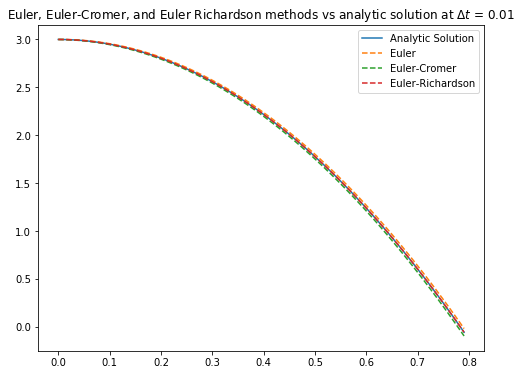

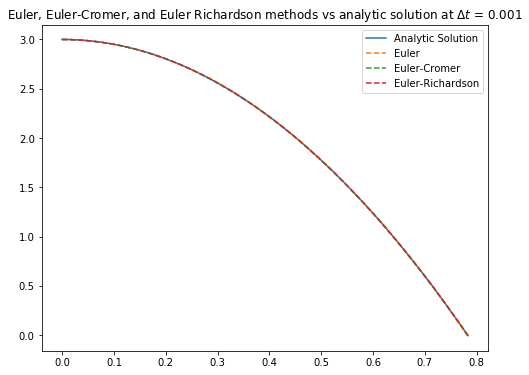

In [217]:
# Loop over 4 different values of dt to compare the results
for delta_t in [0.1, 0.05, 0.01, 0.001]:
    # Get the "true" results from the analytic solution
    t = np.arange(time_interval[0], time_interval[1] + delta_t, delta_t)
    y = -(1/2)*g*t**2 + y_0[1]*t + y_0[0]

    
    # Call all three different Euler methods and get the results
    t_e, y_e = solve_ode(simple_gravity, time_interval, y_0, Euler, g, first_step=delta_t)
    t_e_c, y_e_c = solve_ode(simple_gravity, time_interval, y_0, EulerCromer, g, first_step=delta_t)
    t_e_r, y_e_r = solve_ode(simple_gravity, time_interval, y_0, EulerRichardson, g, first_step=delta_t)
    
    # Plot the results for each dt
    plt.subplots(figsize=(8, 6))
    plt.plot(t, y)
    plt.plot(t_e, y_e[:, 0], '--')
    plt.plot(t_e_c, y_e_c[:, 0], '--')
    plt.plot(t_e_r, y_e_r[:, 0], '--')
    plt.legend(['Analytic Solution', 'Euler', 'Euler-Cromer', 'Euler-Richardson'])
    plt.title(f'Euler, Euler-Cromer, and Euler Richardson methods vs analytic solution at $\Delta t$ = {delta_t}')
    plt.show()

### Problem 5 

Find the slope of the curve that results when plotting error vs. $\Delta t$. Use the `loglog` function to do the plotting. Refer back to the section on fractals to learn how to do this type of plot and curve fitting. We are looking for the exponent in the relationship 

$$\textrm{error} \propto \Delta t^{\alpha}$$

Before carying out this exercise, make sure you know what a desirable $\alpha$ is vs. an undesirable $\alpha$.

Make sure to find the errors for a large range of $\Delta t$s. I suggest you become familiar with the `logspace` function in `numpy`.

In [228]:
from scipy.stats import linregress

def error_scale(steps, errors, plot=True):
    """
    INPUTS -
        steps = a vector of the steps, this will be better if they are logspaced
        errors = a vector errors, usually |y - y_analytic|
        plot = a boolean telling the method to plot, or not
    """
    # Convert delta t steps and errors to log space
    log_steps = np.log10(steps)
    log_errors = np.log10(errors)

    # Run a linear regression error vs. steps
    regression = scipy.stats.linregress(log_steps, log_errors)
    x = np.linspace(np.min(log_steps), np.max(log_steps), 1000)
    y = regression.slope * x + regression.intercept

    if plot:
        plt.plot(log_steps, log_errors, 'k.')
        plt.plot(x, y, 'r-')
        plt.title(f'Slope is {regression.slope:.2f}')
        plt.xlabel('$\log(\Delta t)$')
        plt.ylabel('$\log(error)$')
        plt.show()

    # return regression.slope, x, y


def error(y, y_a):
    """
    Simple convenience to compute errors between y and y_a
    the numerical (y) and the analytic solution (y_a)
    """
    # Returns L2 norm of the difference between estimated and analytic solutions
    return np.linalg.norm(y - y_a)


dts = np.logspace(-4, -1, 40)  # You will want these spaced out over several decades


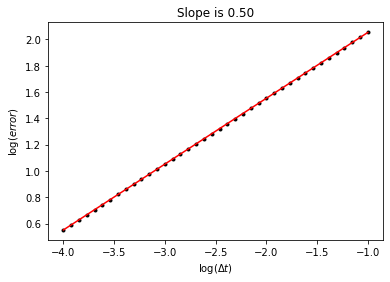

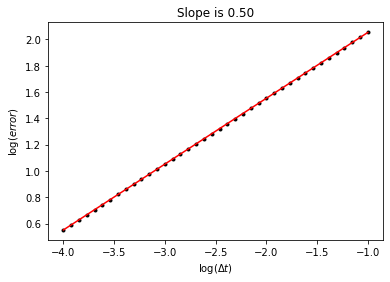

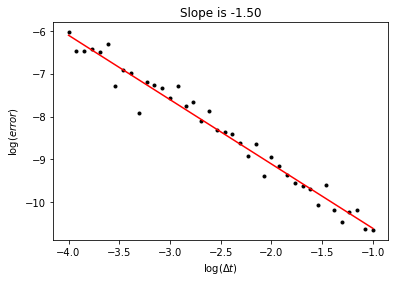

In [229]:
# Initialize storage for the errors at each dt
error_e = list()
error_e_c = list()
error_e_r = list()

for dt in dts:
    # Compute analytic solution for dt
    t = np.arange(time_interval[0], time_interval[1] + dt, dt)
    y = -(1/2)*g*t**2 + y_0[1]*t + y_0[0]
    
    # Call all three different Euler methods and get the results
    t_e, y_e = solve_ode(simple_gravity, time_interval, y_0, Euler, g, first_step=dt)
    t_e_c, y_e_c = solve_ode(simple_gravity, time_interval, y_0, EulerCromer, g, first_step=dt)
    t_e_r, y_e_r = solve_ode(simple_gravity, time_interval, y_0, EulerRichardson, g, first_step=dt)
    
    # Compute the errors of all three Euler methods, append to the list
    error_e.append(error(y_e[:, 0], y))
    error_e_c.append(error(y_e_c[:, 0], y))
    error_e_r.append(error(y_e_r[:, 0], y))
    
# Regress error on dts for each method
error_scale(dts, error_e, plot=True)
error_scale(dts, error_e_c, plot=True)
error_scale(dts, error_e_r, plot=True)

The first two graphs suggest that with the Euler and Euler Cramer methods, $\textrm{error} \propto \Delta t ^ {.50}$. That is, as $\Delta t$ gets small, then the error will decrease proportionally to the square root of $\Delta t$. However, we get an odd result with the Euler Richardson method.

Assuming that I haven't made an error in my code (very possible despite a couple hours of looking), then this last graph suggests exponential decay between the error and $\Delta t$. This means that changes to $\Delta t$ will lead to smaller and smaller changes in the error, and that there is certainly a point of diminishing returns where it doesn't make sense to lower $\Delta t$ anymore given decreasing improvements in the error.

### Problem 6

Finally, implement the function describing simple harmonic motion. This is determined from the following equations

$$ \frac{d^2y}{dt^2} = -\frac{k}{m} y $$

Use $k=1$, $m = 1$, $y_0 = .5$, $t_0=0$, $t_f=2\pi \cdot 4$.

Follow the procedure used above: first plot position vs. time for each of the three algorithms, then plot the errors as a function of the time step. Are there differences in the errors? Where, how, what? The analytic solution for this system is:

$$ \omega_0 = \sqrt{\frac{k}{m}}$$

$$ y(t) = y_0 \cos(\omega_0 t) + \frac{v_0}{\omega_0} \sin(\omega_0 t) $$

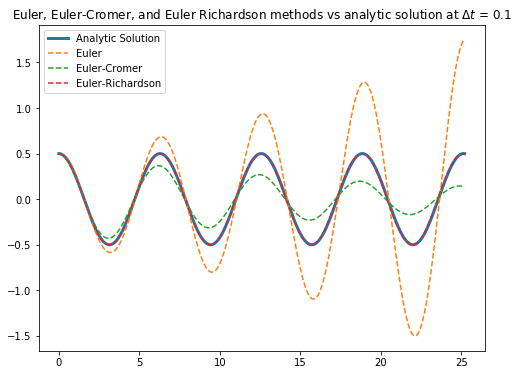

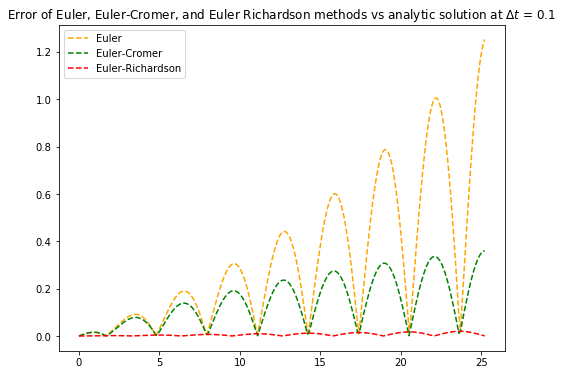

In [226]:
def sho(t,y,k, m):
    """
    The simple harmonic oscillator
    dy/dt = v
    dv/dt = -k/m y
    """
    return np.array([y[1], -k/m * y[0]])

# Initialize constants/time/starting position
k = 1
m = 1
y_0 = np.array([0.5, 0])
time_interval = (0, 8*np.pi)
dt = 0.1

# Find analytic solution
t_a = np.arange(0, 8*np.pi + dt, dt)
y_a = y_0[0] * np.cos(np.sqrt(k / m) * t_a) + (y_0[1] / np.sqrt(k / m)) * np.sin(np.sqrt(k / m) * t_a)

# Find solution with Euler methods
t_e, y_e = solve_ode(sho, time_interval, y_0, Euler, k, m, first_step=dt)
t_e_c, y_e_c = solve_ode(sho, time_interval, y_0, EulerCromer, k, m, first_step=dt)
t_e_r, y_e_r = solve_ode(sho, time_interval, y_0, EulerRichardson, k, m, first_step=dt)

# Compute errors of each Euler method
error_e = np.sqrt(np.square(y_e[:, 0] - y_a))
error_e_c = np.sqrt(np.square(y_e_c[:, 0] - y_a))
error_e_r = np.sqrt(np.square(y_e_r[:, 0] - y_a))
    
# Plot the basic behavior of all 3 algorithms over the time of interest
plt.subplots(figsize=(8, 6))
plt.plot(t_a, y_a, lw=3)
plt.plot(t_e, y_e[:, 0], '--')
plt.plot(t_e_c, y_e_c[:, 0], '--')
plt.plot(t_e_r, y_e_r[:, 0], '--')
plt.legend(['Analytic Solution', 'Euler', 'Euler-Cromer', 'Euler-Richardson'])
plt.title(f'Euler, Euler-Cromer, and Euler Richardson methods vs analytic solution at $\Delta t$ = {dt}')
plt.show()

# Plot errors of all 3 algorithms
plt.subplots(figsize=(8, 6))
plt.plot(t_e, error_e, '--', c='orange')
plt.plot(t_e_c, error_e_c, '--', c='green')
plt.plot(t_e_r, error_e_r, '--', c='red')
plt.legend(['Euler', 'Euler-Cromer', 'Euler-Richardson'])
plt.title(f'Error of Euler, Euler-Cromer, and Euler Richardson methods vs analytic solution at $\Delta t$ = {dt}')
plt.show()

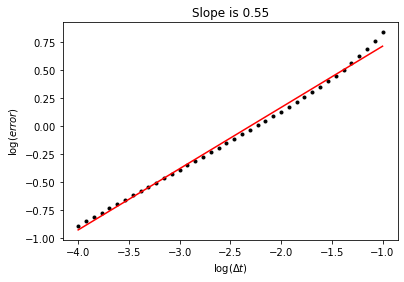

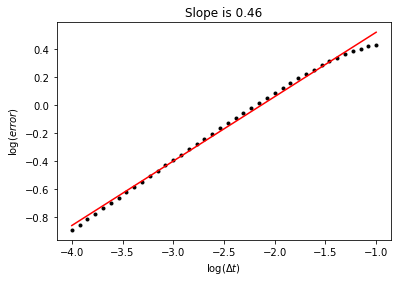

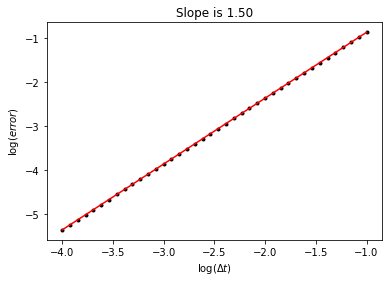

In [230]:
# Conduct the complete error analysis
dts = np.logspace(-1, -4, 40)  # You will want these spaced out over several decades

# Initialize storage for the errors at each dt
error_e = list()
error_e_c = list()
error_e_r = list()

for dt in dts:
    # Compute analytic solution for dt
    t_a = np.arange(0, 8*np.pi + dt, dt)
    y_a = y_0[0] * np.cos(np.sqrt(k / m) * t_a) + (y_0[1] / np.sqrt(k / m)) * np.sin(np.sqrt(k / m) * t_a)
    
    # Call all three different Euler methods and get the results
    t_e, y_e = solve_ode(sho, time_interval, y_0, Euler, k, m, first_step=dt)
    t_e_c, y_e_c = solve_ode(sho, time_interval, y_0, EulerCromer, k, m, first_step=dt)
    t_e_r, y_e_r = solve_ode(sho, time_interval, y_0, EulerRichardson, k, m, first_step=dt)
    
    # Compute the errors of all three Euler methods, append to the list
    error_e.append(error(y_e[:, 0], y_a))
    error_e_c.append(error(y_e_c[:, 0], y_a))
    error_e_r.append(error(y_e_r[:, 0], y_a))
    
# Regress error on dts for each method
error_scale(dts, error_e, plot=True)
error_scale(dts, error_e_c, plot=True)
error_scale(dts, error_e_r, plot=True)

Interestingly, the plots above show the same error - $\Delta t$ relationship as we observed for the falling body with the first two methods, but we see the opposite behavior for the Euler-Richardson equations. So for the Euler and Euler Cramer methods, the two plots above suggest that $\textrm{error} \propto \Delta t ^ {.55}$ and $\textrm{error} \propto \Delta t ^ {.46}$ respectively. However, for the Euler-Richardson method $\textrm{error} \propto \Delta t ^ {1.50}$. This suggests that as $\Delta t \rightarrow 0$, then the error between the analytic solution and the approximation will decrease by a whole power faster than the Euler or Euler Cramer methods.